In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [1]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [3]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [4]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [5]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [6]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [7]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [10]:

app_store_scrapperNtransformer(app_name="Lomotif: Edit Video. Add Music",country="sg",
                           how_many=5000,export_csv_name="lomotif_data_sg.csv")

# Status: Completed

2021-10-17 01:13:38,275 [INFO] Base - Searching for app id
2021-10-17 01:13:42,676 [INFO] Base - Initialised: AppStore('sg', 'lomotif-edit-video-add-music', 884009993)
2021-10-17 01:13:42,677 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/sg/app/lomotif-edit-video-add-music/id884009993
2021-10-17 01:13:44,620 [INFO] Base - [id:884009993] Fetched 34 reviews (34 fetched in total)


# Basic Data Preparation

In [13]:
# Import scrapped data
tiktok_ios_sg_review = pd.read_csv("tiktok_data_sg.csv")

In [14]:
# Inspect the data
tiktok_ios_sg_review.head()

,Unnamed: 0,review,rating,isEdited,date,userName,title,developerResponse
0,0,Have suggestion to make it easier for the user to find videos that they like to put (add folder) or (create folder) because it is really difficult and time wasting to look for some specific videos...,5,False,2020-05-01 04:21:04,kawaii_noda,To add folder in like,NaN
1,1,"okay so i’ve been using tiktok since 2016. it has been a HUGE influence in my life and i just wanted to say thank you to that. now, to the problem. recently i got a new ipad. and i was super happy...",3,False,2021-08-15 07:52:23,thidis5,different devices problem,NaN
2,2,I really like this app and I’m obsessed with it until something weird happened to my acc. I got a new phone and it was working fine until last week and suddenly nothing is working. The for you pag...,5,False,2019-03-04 14:22:03,lb.norah,It’s good but....,"{'id': 9604605, 'body': ""Hey,we're sorry to hear that you've been unable to update the app on your device. We've resolved this issue in the app but please reach out to our support team for help if..."
3,3,"Hi tiktok so I have been using tiktok a lot these days and I just experienced this for like 2 days. So my FYP is usually Anime, couples, zodiac sign or just random things. But since yesterday, my ...",4,True,2020-12-12 16:33:01,le thi yen nhu,Is this a glitch,"{'id': 12306679, 'body': 'Hi, sorry for the unpleasant experience, you can contact us through our app (Profile—Top right button—Privacy and settings—report a problem). We will try our best to sol..."
4,4,"it might seem easy to gain followers but instead it’s more harder than you think. You have to spend time creating what you want to post, but after an hour or less you finish the item you want to p...",3,False,2020-11-21 10:29:55,Koh Peh Xin,hard to gain followers,NaN


In [15]:
# Sort by date, only keep data between 2018 and 2021, clean columns
tiktok_ios_sg_review_YearMonth = (tiktok_ios_sg_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
tiktok_ios_sg_review_YearMonth['date'] = pd.to_datetime(tiktok_ios_sg_review_YearMonth['date']).dt.floor('d')

# Create year column
tiktok_ios_sg_review_YearMonth['year'] = pd.DatetimeIndex(tiktok_ios_sg_review_YearMonth['date']).year

# Create month column
tiktok_ios_sg_review_YearMonth['month'] = pd.DatetimeIndex(tiktok_ios_sg_review_YearMonth['date']).month

In [16]:
# Inspect the dataframe again after cleaning
tiktok_ios_sg_review_YearMonth.head()

,review,rating,isEdited,date,userName,title,developerResponse,year,month
1,Really have fun,5,False,2018-03-07,知足^ _ ^,Good,NaN,2018,3
2,Waited for this app to download for about an hour and it still hasn’t download yet,1,False,2018-03-17,Daisy Poon,Can’t Download,NaN,2018,3
3,👍🏼,4,False,2018-03-21,Gwen aRMy,👍🏼,NaN,2018,3
4,很好玩,5,False,2018-03-22,心语日记你真棒,嘿,NaN,2018,3
5,为什么新加坡的版本没有简体中文？,5,False,2018-03-22,Msyyhwnj,？？？？,NaN,2018,3


# EDA

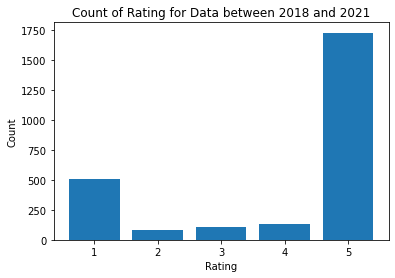

In [17]:
# Plot the count of different ratings for data between 2018 and 2021
tiktok_ios_sg_review_score_count = tiktok_ios_sg_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(tiktok_ios_sg_review_score_count.index,tiktok_ios_sg_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

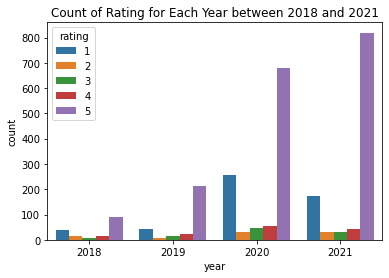

In [18]:
# Plot the count of different ratings for each year
tiktok_ios_sg_review_score_count_ByYear = (tiktok_ios_sg_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=tiktok_ios_sg_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [19]:
# Understand average ratings over year
tiktok_ios_sg_review_avg_score_ByYear = (tiktok_ios_sg_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

tiktok_ios_sg_review_avg_score_ByYear['count'] = tiktok_ios_sg_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
tiktok_ios_sg_review_avg_score_ByYear

Average ratings and count of each year:


,rating,count
year,,
2018,3.659091,172
2019,4.196774,303
2020,3.884917,1070
2021,4.275806,1093


# Dataframe Preparation for Topic Modelling

In [20]:
# Dataframe with data between 2018 and 2021 without score or year filtering
tiktok_ios_sg_review_YearMonth.head()

,review,rating,isEdited,date,userName,title,developerResponse,year,month
1,Really have fun,5,False,2018-03-07,知足^ _ ^,Good,NaN,2018,3
2,Waited for this app to download for about an hour and it still hasn’t download yet,1,False,2018-03-17,Daisy Poon,Can’t Download,NaN,2018,3
3,👍🏼,4,False,2018-03-21,Gwen aRMy,👍🏼,NaN,2018,3
4,很好玩,5,False,2018-03-22,心语日记你真棒,嘿,NaN,2018,3
5,为什么新加坡的版本没有简体中文？,5,False,2018-03-22,Msyyhwnj,？？？？,NaN,2018,3


In [21]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
tiktok_ios_sg_review_YearMonth_score1 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating']==1]
tiktok_ios_sg_review_YearMonth_score2 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating']==2]
tiktok_ios_sg_review_YearMonth_score3 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating']==3]
tiktok_ios_sg_review_YearMonth_score4 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating']==4]
tiktok_ios_sg_review_YearMonth_score5 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating']==5]


In [114]:
# Prepare dataframe for grouped score
tiktok_ios_sg_review_YearMonth_score1N2N3 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating'].isin([1,2,3])]
tiktok_ios_sg_review_YearMonth_score4N5 = tiktok_ios_sg_review_YearMonth[tiktok_ios_sg_review_YearMonth['rating'].isin([4,5])]


In [155]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
tiktok_ios_sg_review_YearMonth_2018_score1N2N3 = tiktok_ios_sg_review_YearMonth[(tiktok_ios_sg_review_YearMonth['year']==2018)&(tiktok_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_sg_review_YearMonth_2019_score1N2N3 = tiktok_ios_sg_review_YearMonth[(tiktok_ios_sg_review_YearMonth['year']==2019)&(tiktok_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_sg_review_YearMonth_2020_score1N2N3 = tiktok_ios_sg_review_YearMonth[(tiktok_ios_sg_review_YearMonth['year']==2020)&(tiktok_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_sg_review_YearMonth_2021_score1N2N3 = tiktok_ios_sg_review_YearMonth[(tiktok_ios_sg_review_YearMonth['year']==2021)&(tiktok_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [25]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_sg = tiktok_ios_sg_review_YearMonth.review.values.tolist()
review_words_sg = list(sent_to_words(review_sg))
print(review_words_sg[:1])

[['really', 'have', 'fun']]


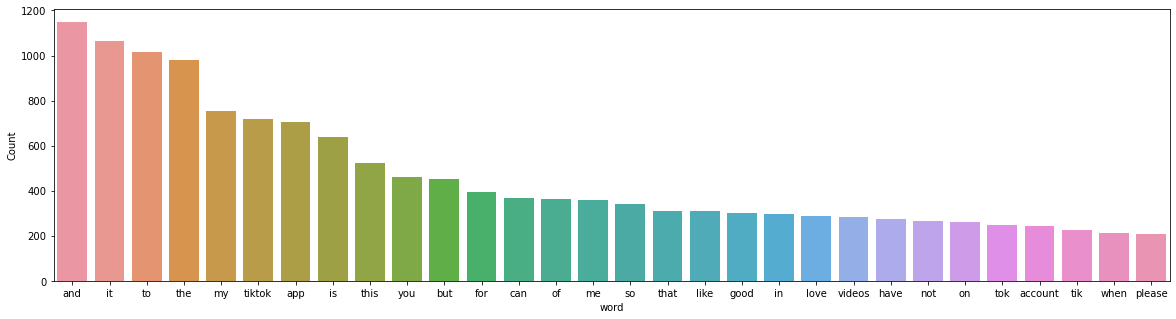

In [26]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg))

In [27]:
# Clean text
review_sg_ready = process_words(review_words_sg)  # processed Text Data! - move to each section

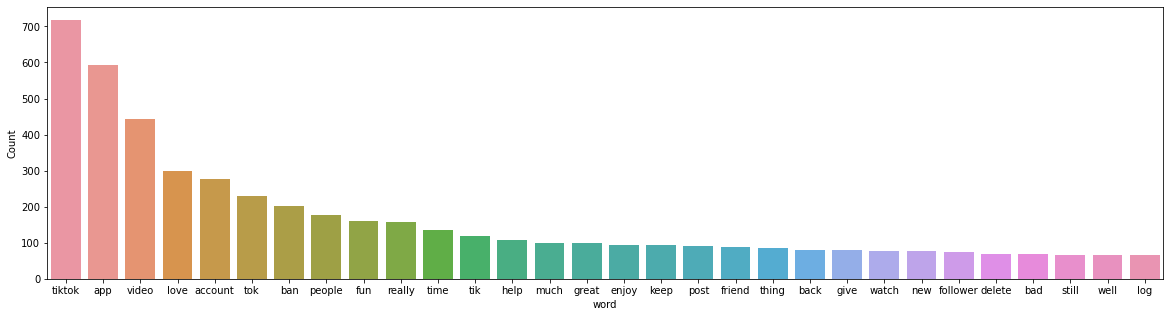

In [28]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready))

In [29]:
# Create Dictionary
id2word_sg = corpora.Dictionary(review_sg_ready)

In [30]:
# Create Corpus: Term Document Frequency
corpus_sg = [id2word_sg.doc2bow(text) for text in review_sg_ready]

In [31]:
# Training LDA model
model_list_sg, coherence_values_sg = compute_coherence_values(dictionary=id2word_sg, corpus=corpus_sg, 
                                                              texts=review_sg_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

In [241]:
%store model_list_sg
%store coherence_values_sg

Stored 'model_list_sg' (list)
Stored 'coherence_values_sg' (list)


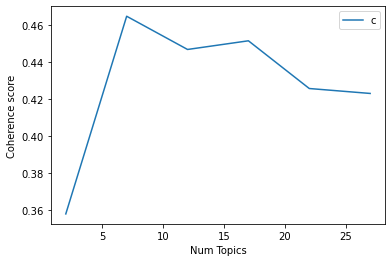

In [32]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.358
index: 1 | Num Topics = 7  has Coherence Value of 0.4648
index: 2 | Num Topics = 12  has Coherence Value of 0.4469
index: 3 | Num Topics = 17  has Coherence Value of 0.4516
index: 4 | Num Topics = 22  has Coherence Value of 0.4258
index: 5 | Num Topics = 27  has Coherence Value of 0.4231


In [34]:
# Select optimal number of topics
optimal_model_sg = model_list_sg[1]

In [35]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg = pyLDAvis.gensim_models.prepare(optimal_model_sg, corpus_sg, id2word_sg)

In [36]:
print("pyLDAVis for overall SG topics:")
vis_sg

pyLDAVis for overall SG topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.167940  0.124359       1        1  18.840362
4     -0.071420 -0.133332       2        1  17.189717
1      0.136127 -0.042213       3        1  17.082747
2     -0.196854  0.166431       4        1  14.437892
5      0.098089 -0.059157       5        1  12.437891
6     -0.113269 -0.137588       6        1  10.769486
3     -0.020614  0.081500       7        1   9.241905, topic_info=        Term        Freq       Total Category  logprob  loglift
53   account  248.000000  248.000000  Default  30.0000  30.0000
41      love  262.000000  262.000000  Default  29.0000  29.0000
20       tok  198.000000  198.000000  Default  28.0000  28.0000
2        app  503.000000  503.000000  Default  27.0000  27.0000
25     video  375.000000  375.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
26      view   10.802294   54.255808   Topic7  -4.8804   0.7675
90      back   11.504054   69.032005   Topic7  -4.8175   0.5896
127    start    9.302668   31.872477   Topic7  -5.0299   1.1500
430    bring    7.862523   17.489077   Topic7  -5.1981   1.5820
111      fix    8.039496   54.864729   Topic7  -5.1758   0.4609

[422 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
64        2  0.069752     able
64        3  0.139504     able
64        4  0.767273     able
200       2  0.681751      acc
200       4  0.292179      acc
...     ...       ...      ...
206       1  0.346276     year
206       5  0.288563     year
206       7  0.346276     year
7         3  0.932833      yet
562       2  0.803222  youtube

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 6, 7, 4])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [37]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_sg_score1 = tiktok_ios_sg_review_YearMonth_score1.review.values.tolist()
review_words_sg_score1 = list(sent_to_words(review_sg_score1))
print(review_words_sg_score1[:1])

[['waited', 'for', 'this', 'app', 'to', 'download', 'for', 'about', 'an', 'hour', 'and', 'it', 'still', 'hasn', 'download', 'yet']]


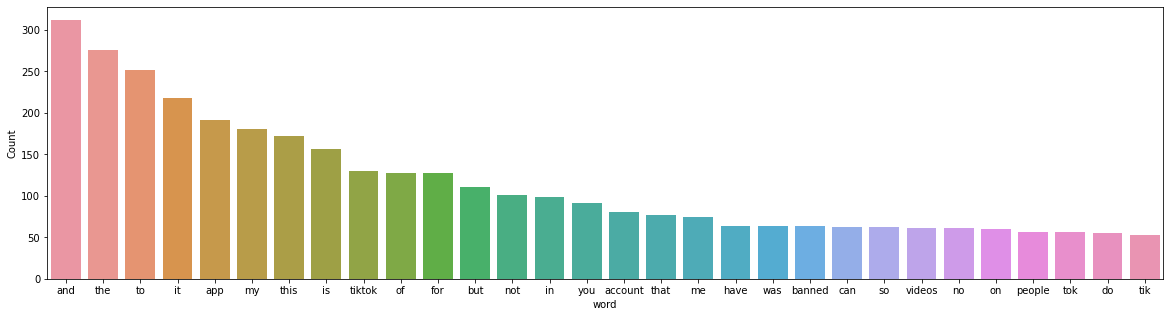

In [38]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1))

In [39]:
# Clean text
review_sg_ready_score1 = process_words(review_words_sg_score1)  # processed Text Data! - move to each section


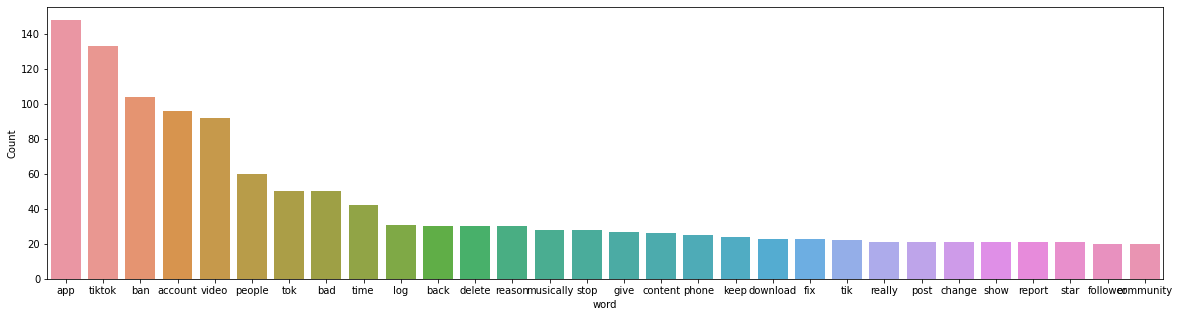

In [40]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1))


In [41]:
# Create Dictionary
id2word_sg_score1 = corpora.Dictionary(review_sg_ready_score1)

In [42]:
# Create Corpus: Term Document Frequency
corpus_sg_score1 = [id2word_sg_score1.doc2bow(text) for text in review_sg_ready_score1]

In [43]:
# Training LDA model
model_list_sg_score1, coherence_values_sg_score1 = compute_coherence_values(dictionary=id2word_sg_score1, corpus=corpus_sg_score1, 
                                                              texts=review_sg_ready_score1, limit=30, start=2, step=5)


In [102]:
%store model_list_sg_score1
%store coherence_values_sg_score1

Stored 'model_list_sg_score1' (list)
Stored 'coherence_values_sg_score1' (list)


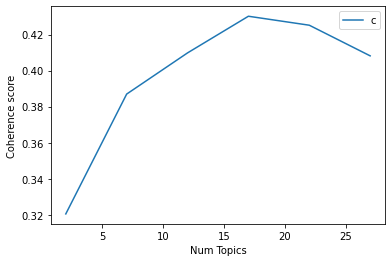

In [149]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [151]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3205
index: 1 | Num Topics = 7  has Coherence Value of 0.387
index: 2 | Num Topics = 12  has Coherence Value of 0.4098
index: 3 | Num Topics = 17  has Coherence Value of 0.4301
index: 4 | Num Topics = 22  has Coherence Value of 0.4252
index: 5 | Num Topics = 27  has Coherence Value of 0.4082


In [152]:
# Select optimal number of topics
optimal_model_sg_score1 = model_list_sg_score1[3]

In [153]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1, corpus_sg_score1, id2word_sg_score1)

In [154]:
print("pyLDAVis for SG topics for score=1:")
vis_sg_score1

pyLDAVis for SG topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.161788 -0.114013       1        1  17.845833
15    -0.139448 -0.216905       2        1   9.365267
3     -0.013473  0.043493       3        1   7.483818
1      0.102036 -0.076359       4        1   6.771694
4      0.056641  0.009216       5        1   6.418927
13     0.005948  0.047082       6        1   5.495950
7     -0.010556 -0.017712       7        1   5.059740
8      0.111617 -0.025737       8        1   4.934061
14    -0.000779  0.102700       9        1   4.905066
9      0.041780 -0.036158      10        1   4.818768
10    -0.121286 -0.042321      11        1   4.798993
5      0.027471  0.126901      12        1   4.677588
2     -0.110561  0.066007      13        1   4.548933
12     0.055172  0.027508      14        1   4.040093
0     -0.126642  0.006513      15        1   3.551222
16    -0.040910  0.049478      16        1   2.875141
6      0.001204  0.050306      17        1   2.408906, topic_info=        Term      Freq      Total Category  logprob  loglift
91       bad  36.00000  36.000000  Default  30.0000  30.0000
493      ban  87.00000  87.000000  Default  29.0000  29.0000
14       tok  38.00000  38.000000  Default  28.0000  28.0000
22   account  80.00000  80.000000  Default  27.0000  27.0000
126     time  34.00000  34.000000  Default  26.0000  26.0000
..       ...       ...        ...      ...      ...      ...
218    music   0.68163   4.690298  Topic17  -4.9843   1.7972
333    trend   0.68163   5.423870  Topic17  -4.9843   1.6519
503    steal   0.68163   5.402275  Topic17  -4.9843   1.6559
542  promote   0.68163   5.499571  Topic17  -4.9843   1.6381
243     keep   0.68163  19.175981  Topic17  -4.9843   0.3891

[977 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1146      4  0.647929    absolute
587      16  0.714782  absolutely
966       1  0.777963         acc
927       4  0.647929  acceptable
732       5  0.648398    accident
...     ...       ...         ...
435      11  0.673943     安装后不能运行
403      15  0.678817      建立了一个吧
33       11  0.673941          抖音
436      11  0.673943        最新版本
205      12  0.668550     没有中国版的吗

[1472 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 16, 4, 2, 5, 14, 8, 9, 15, 10, 11, 6, 3, 13, 1, 17, 7])

## LDA Topic Modelling (Rating = 2)

In [49]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_sg_score2 = tiktok_ios_sg_review_YearMonth_score2.review.values.tolist()
review_words_sg_score2 = list(sent_to_words(review_sg_score2))
print(review_words_sg_score2[:1])

[['have', 'created', 'an', 'account', 'and', 'post', 'videos', 'already', 'now', 'changed', 'phone', 'and', 'apple', 'id', 'change', 'to', 'singapore', 'store', 'then', 'cannot', 'use', 'my', 'wechat', 'account', 'any', 'more', 'so', 'inconvenient']]


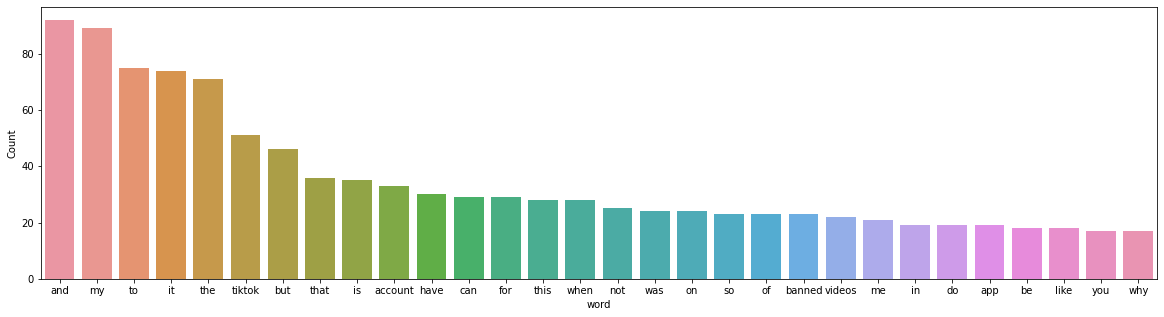

In [50]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score2))

In [51]:
# Clean text
review_sg_ready_score2 = process_words(review_words_sg_score2)  # processed Text Data! - move to each section


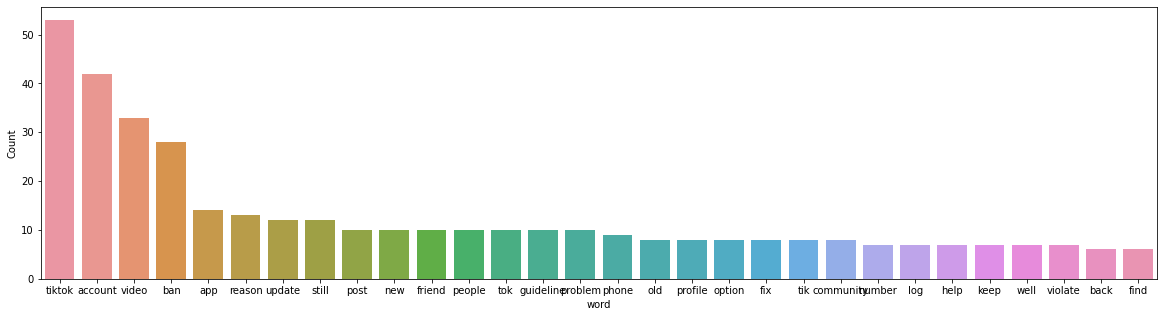

In [52]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score2))


In [53]:
# Create Dictionary
id2word_sg_score2 = corpora.Dictionary(review_sg_ready_score2)

In [54]:
# Create Corpus: Term Document Frequency
corpus_sg_score2 = [id2word_sg_score2.doc2bow(text) for text in review_sg_ready_score2]

In [55]:
# Training LDA model
model_list_sg_score2, coherence_values_sg_score2 = compute_coherence_values(dictionary=id2word_sg_score2, corpus=corpus_sg_score2, 
                                                              texts=review_sg_ready_score2, limit=30, start=2, step=5)


In [101]:
%store model_list_sg_score2
%store coherence_values_sg_score2

Stored 'model_list_sg_score2' (list)
Stored 'coherence_values_sg_score2' (list)


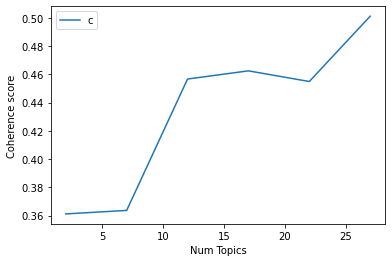

In [144]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [145]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3611
index: 1 | Num Topics = 7  has Coherence Value of 0.3636
index: 2 | Num Topics = 12  has Coherence Value of 0.4567
index: 3 | Num Topics = 17  has Coherence Value of 0.4625
index: 4 | Num Topics = 22  has Coherence Value of 0.455
index: 5 | Num Topics = 27  has Coherence Value of 0.5012


In [146]:
# Select optimal number of topics
optimal_model_sg_score2 = model_list_sg_score2[5]

In [147]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score2 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score2, corpus_sg_score2, id2word_sg_score2)

In [148]:
print("pyLDAVis for SG topics for score=2:")
vis_sg_score2

pyLDAVis for SG topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12    -0.030766  0.131174       1        1  8.879686
25     0.081744 -0.049776       2        1  8.301170
5      0.136995 -0.032016       3        1  7.436565
18     0.070601 -0.056255       4        1  6.159245
16    -0.059343 -0.086564       5        1  5.608596
15     0.121349 -0.101903       6        1  5.596103
17    -0.094969 -0.103606       7        1  5.054393
7      0.048384  0.111654       8        1  4.622000
26    -0.089680 -0.133616       9        1  4.378804
19     0.078697 -0.046338      10        1  4.138967
21     0.130276 -0.010675      11        1  3.854788
3      0.121106 -0.041032      12        1  3.598905
20     0.087063  0.116274      13        1  3.502028
23    -0.037071 -0.027422      14        1  3.317607
14     0.062784  0.020341      15        1  3.304796
22    -0.104900  0.057478      16        1  3.132909
0     -0.045080 -0.044287      17        1  3.121664
8     -0.060812  0.140866      18        1  3.069217
4     -0.114632 -0.087885      19        1  2.856515
9     -0.084705 -0.011980      20        1  2.484110
13    -0.009560  0.020504      21        1  1.920013
1     -0.027497  0.119755      22        1  1.846494
2     -0.084666 -0.023746      23        1  1.195365
6      0.015075  0.031937      24        1  1.193576
24    -0.011608  0.049762      25        1  0.810259
11    -0.046254  0.024597      26        1  0.369443
10    -0.052527  0.032758      27        1  0.246781, topic_info=        Term       Freq      Total Category  logprob  loglift
135      ban  20.000000  20.000000  Default  30.0000  30.0000
0    account  32.000000  32.000000  Default  29.0000  29.0000
60    tiktok  39.000000  39.000000  Default  28.0000  28.0000
57       app  10.000000  10.000000  Default  27.0000  27.0000
9      video  25.000000  25.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
25      sure   0.006111   2.230344  Topic27  -6.0845   0.1045
26    update   0.006111   9.814077  Topic27  -6.0845  -1.3771
27       ver   0.006111   1.426221  Topic27  -6.0845   0.5516
28    number   0.006111   5.894939  Topic27  -6.0845  -0.8674
29   profile   0.006111   6.039923  Topic27  -6.0845  -0.8917

[1130 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
70       12  0.484711   able
106       9  0.727065     ac
47        1  0.268277    acc
47        2  0.268277    acc
47       10  0.268277    acc
...     ...       ...    ...
55        1  0.252189   year
55        2  0.252189   year
55        3  0.504378   year
438       4  0.689022    yet
251       6  0.697084  young

[798 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 26, 6, 19, 17, 16, 18, 8, 27, 20, 22, 4, 21, 24, 15, 23, 1, 9, 5, 10, 14, 2, 3, 7, 25, 12, 11])

## LDA Topic Modelling (Rating = 3)

In [61]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_sg_score3 = tiktok_ios_sg_review_YearMonth_score3.review.values.tolist()
review_words_sg_score3 = list(sent_to_words(review_sg_score3))
print(review_words_sg_score3[:1])

[['not', 'able', 'to', 'find', 'lot', 'of', 'users', 'that', 'are', 'based', 'in', 'mainland', 'china', 'different', 'versions', 'of', 'app', 'hope', 'tik', 'tok', 'will', 'be', 'able', 'to', 'let', 'everyone', 'view', 'everyone', 'videos']]


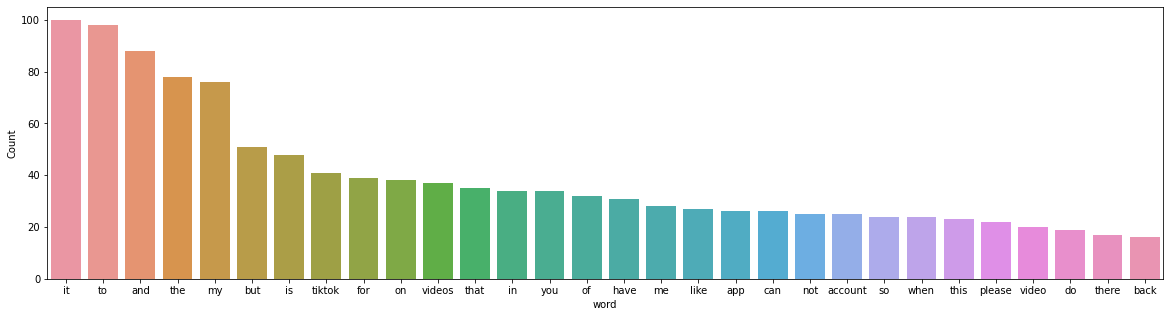

In [62]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score3))

In [63]:
# Clean text
review_sg_ready_score3 = process_words(review_words_sg_score3)  # processed Text Data! - move to each section


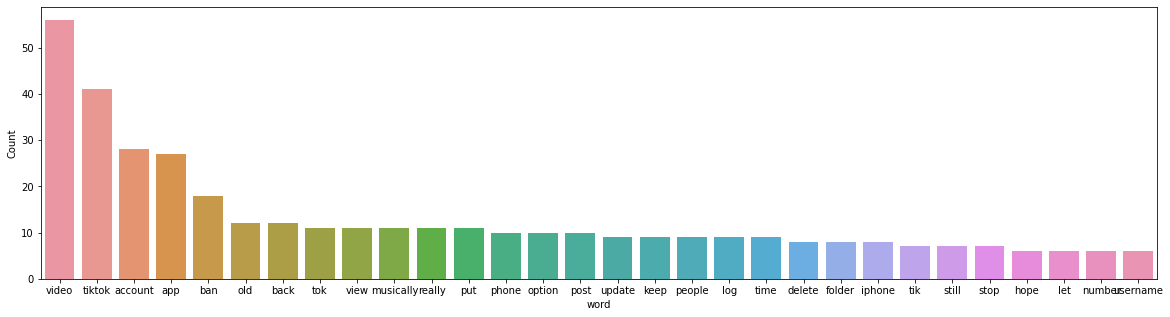

In [64]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score3))


In [65]:
# Create Dictionary
id2word_sg_score3 = corpora.Dictionary(review_sg_ready_score3)

In [66]:
# Create Corpus: Term Document Frequency
corpus_sg_score3 = [id2word_sg_score3.doc2bow(text) for text in review_sg_ready_score3]

In [67]:
# Training LDA model
model_list_sg_score3, coherence_values_sg_score3 = compute_coherence_values(dictionary=id2word_sg_score3, corpus=corpus_sg_score3, 
                                                              texts=review_sg_ready_score3, limit=30, start=2, step=5)


In [100]:
%store model_list_sg_score3
%store coherence_values_sg_score3

Stored 'model_list_sg_score3' (list)
Stored 'coherence_values_sg_score3' (list)


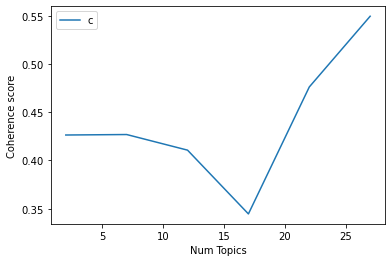

In [139]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [140]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.4264
index: 1 | Num Topics = 7  has Coherence Value of 0.4269
index: 2 | Num Topics = 12  has Coherence Value of 0.4107
index: 3 | Num Topics = 17  has Coherence Value of 0.3446
index: 4 | Num Topics = 22  has Coherence Value of 0.4763
index: 5 | Num Topics = 27  has Coherence Value of 0.5497


In [141]:
# Select optimal number of topics
optimal_model_sg_score3 = model_list_sg_score3[5]

In [142]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score3, corpus_sg_score3, id2word_sg_score3)

In [143]:
print("pyLDAVis for SG topics for score=3:")
vis_sg_score3

pyLDAVis for SG topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.015402 -0.141755       1        1  8.349274
6     -0.118653 -0.093383       2        1  7.031222
9      0.118513 -0.077014       3        1  6.996067
25    -0.031574 -0.120177       4        1  6.508075
21     0.067736 -0.087581       5        1  6.358447
17    -0.022812 -0.150017       6        1  5.924633
10     0.141224  0.125982       7        1  5.559484
23    -0.142141 -0.055098       8        1  5.518214
8      0.071533  0.009187       9        1  5.500830
14     0.107378 -0.078312      10        1  5.297039
4      0.153519  0.003954      11        1  5.075360
5      0.121608 -0.012123      12        1  3.484160
0     -0.049659  0.051565      13        1  3.372793
19    -0.073857  0.053274      14        1  3.067769
22    -0.041712  0.112077      15        1  2.964659
15     0.078100  0.019720      16        1  2.733832
12    -0.152078 -0.001284      17        1  2.718159
20    -0.139014 -0.013885      18        1  2.682422
24    -0.067780  0.091358      19        1  2.531174
2      0.001722  0.029246      20        1  2.490723
18     0.031749 -0.051223      21        1  1.988354
16    -0.012476  0.065732      22        1  1.533976
3     -0.061613  0.037926      23        1  0.894204
26     0.002456  0.089875      24        1  0.577846
13     0.000078  0.068173      25        1  0.308486
1      0.001175  0.061893      26        1  0.266398
7      0.001175  0.061892      27        1  0.266398, topic_info=          Term       Freq      Total Category  logprob  loglift
36     account  20.000000  20.000000  Default  30.0000  30.0000
19      tiktok  31.000000  31.000000  Default  29.0000  29.0000
11       video  44.000000  44.000000  Default  28.0000  28.0000
151        ban  14.000000  14.000000  Default  27.0000  27.0000
135     iphone   6.000000   6.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
3    different   0.006835   3.831326  Topic27  -6.1377  -0.4009
4         find   0.006835   3.684279  Topic27  -6.1377  -0.3618
6          let   0.006835   4.878260  Topic27  -6.1377  -0.6425
7     mainland   0.006835   1.455073  Topic27  -6.1377   0.5672
8          tok   0.006835   8.871081  Topic27  -6.1377  -1.2405

[1185 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.521744      able
0         6  0.260872      able
0        10  0.260872      able
359       9  0.705112     abuse
321       3  0.357600       acc
...     ...       ...       ...
353       1  0.686985      yooo
81        7  0.714083  youngest
88        7  0.714085        抖音
262      18  0.769848      𝚍𝚘𝚠𝚗
263      18  0.769848  𝚜𝚑𝚞𝚝𝚝𝚒𝚗𝚐

[836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 10, 26, 22, 18, 11, 24, 9, 15, 5, 6, 1, 20, 23, 16, 13, 21, 25, 3, 19, 17, 4, 27, 14, 2, 8])

## LDA Topic Modelling (Rating = 4)

In [111]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_sg_score4 = tiktok_ios_sg_review_YearMonth_score4.review.values.tolist()
review_words_sg_score4 = list(sent_to_words(review_sg_score4))
print(review_words_sg_score4[2:3])

[['good', 'app', 'but', 'can', 'like', 'videos', 'on', 'my', 'oppo', 'device', 'can', 'you', 'fix', 'the', 'app']]


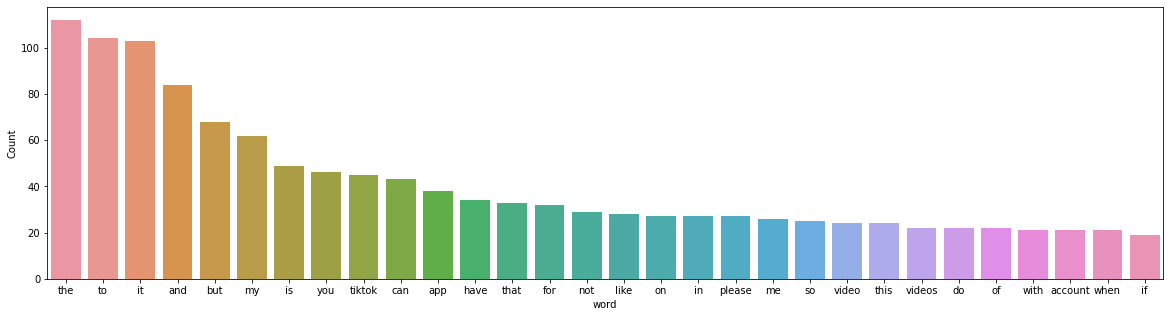

In [74]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score4))

In [75]:
# Clean text
review_sg_ready_score4 = process_words(review_words_sg_score4)  # processed Text Data! - move to each section

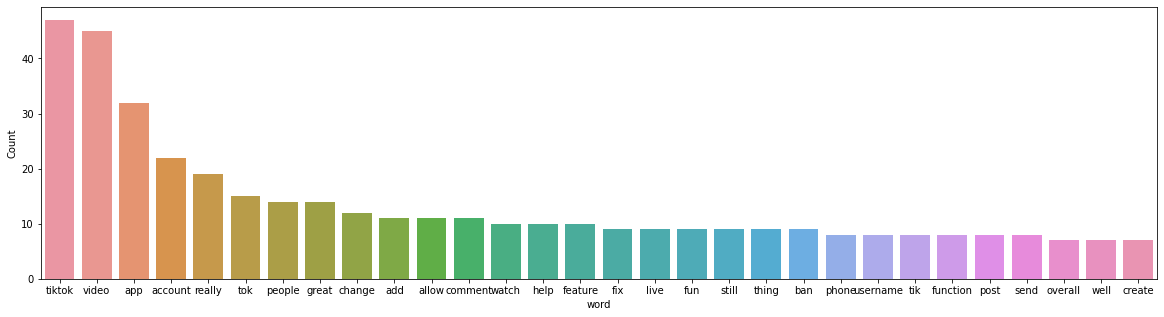

In [76]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score4))


In [77]:
# Create Dictionary
id2word_sg_score4 = corpora.Dictionary(review_sg_ready_score4)

In [78]:
# Create Corpus: Term Document Frequency
corpus_sg_score4 = [id2word_sg_score4.doc2bow(text) for text in review_sg_ready_score4]

In [79]:
# Training LDA model
model_list_sg_score4, coherence_values_sg_score4 = compute_coherence_values(dictionary=id2word_sg_score4, corpus=corpus_sg_score4, 
                                                              texts=review_sg_ready_score4, limit=30, start=2, step=5)


In [99]:
%store model_list_sg_score4
%store coherence_values_sg_score4

Stored 'model_list_sg_score4' (list)
Stored 'coherence_values_sg_score4' (list)


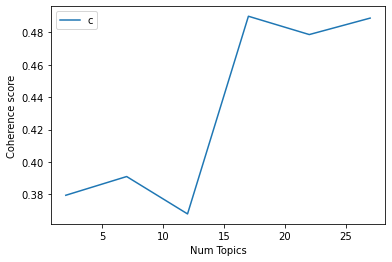

In [134]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  17

index: 0 | Num Topics = 2  has Coherence Value of 0.3795
index: 1 | Num Topics = 7  has Coherence Value of 0.3911
index: 2 | Num Topics = 12  has Coherence Value of 0.368
index: 3 | Num Topics = 17  has Coherence Value of 0.49
index: 4 | Num Topics = 22  has Coherence Value of 0.4787
index: 5 | Num Topics = 27  has Coherence Value of 0.4888


In [136]:
# Select optimal number of topics
optimal_model_sg_score4 = model_list_sg_score4[3]

In [137]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score4 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score4, corpus_sg_score4, id2word_sg_score4)

In [138]:
print("pyLDAVis for SG topics for score=4:")
vis_sg_score4

pyLDAVis for SG topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.014428 -0.051947       1        1  10.641104
7     -0.055210 -0.129258       2        1   9.092414
16    -0.023812 -0.031605       3        1   8.440550
9      0.091607  0.094428       4        1   8.017244
5     -0.143168  0.006869       5        1   7.091581
3      0.078218  0.049327       6        1   7.087613
10     0.054628 -0.029912       7        1   5.506209
4      0.066907 -0.075067       8        1   5.422737
2      0.027420  0.047400       9        1   5.186338
13     0.119632 -0.054933      10        1   4.896833
0      0.098070  0.003394      11        1   4.828519
15    -0.081884 -0.009010      12        1   4.651577
1     -0.095577 -0.027130      13        1   4.527007
12    -0.009980  0.007140      14        1   4.521272
6     -0.054731  0.187536      15        1   4.008822
14    -0.013208 -0.031820      16        1   3.663278
8     -0.044485  0.044588      17        1   2.416902, topic_info=        Term       Freq      Total Category  logprob  loglift
277  comment   9.000000   9.000000  Default  30.0000  30.0000
59    really  13.000000  13.000000  Default  29.0000  29.0000
0        app  24.000000  24.000000  Default  28.0000  28.0000
106  feature   7.000000   7.000000  Default  27.0000  27.0000
14   account  16.000000  16.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
6        ppl   0.031984   2.874112  Topic17  -6.8395  -0.7756
7     expect   0.031984   1.379506  Topic17  -6.8395  -0.0416
8     filter   0.031984   4.329851  Topic17  -6.8395  -1.1854
9        idk   0.031984   1.379506  Topic17  -6.8395  -0.0416
10   overall   0.031984   5.815767  Topic17  -6.8395  -1.4804

[774 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
158       9  0.727140    ability
468       7  0.713754        abt
475      10  0.724896    abusive
181       9  0.491849        acc
181      14  0.491849        acc
...     ...       ...        ...
116       1  0.657854       year
116       5  0.328927       year
394       6  0.681272  yesterday
491      16  0.752799    youtube
395       6  0.681272     zodiac

[887 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 8, 17, 10, 6, 4, 11, 5, 3, 14, 1, 16, 2, 13, 7, 15, 9])

## LDA Topic Modelling (Rating = 5)

In [85]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_sg_score5 = tiktok_ios_sg_review_YearMonth_score5.review.values.tolist()
review_words_sg_score5 = list(sent_to_words(review_sg_score5))
print(review_words_sg_score5[:1])

[['really', 'have', 'fun']]


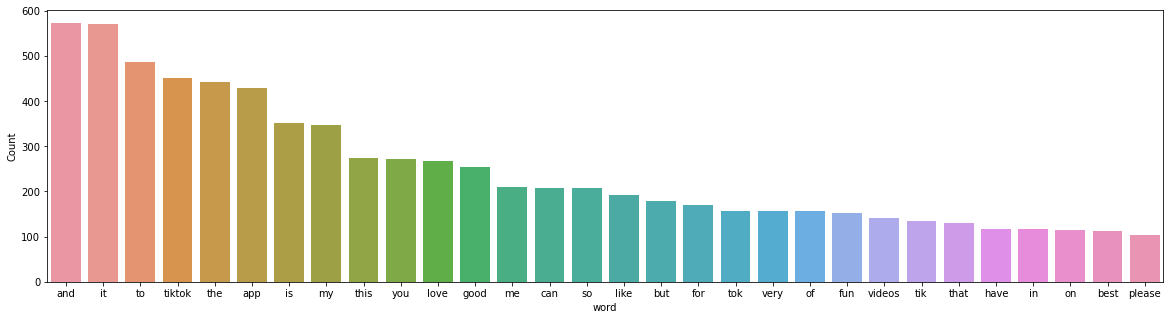

In [86]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score5))

In [87]:
# Clean text
review_sg_ready_score5 = process_words(review_words_sg_score5)  # processed Text Data! - move to each section

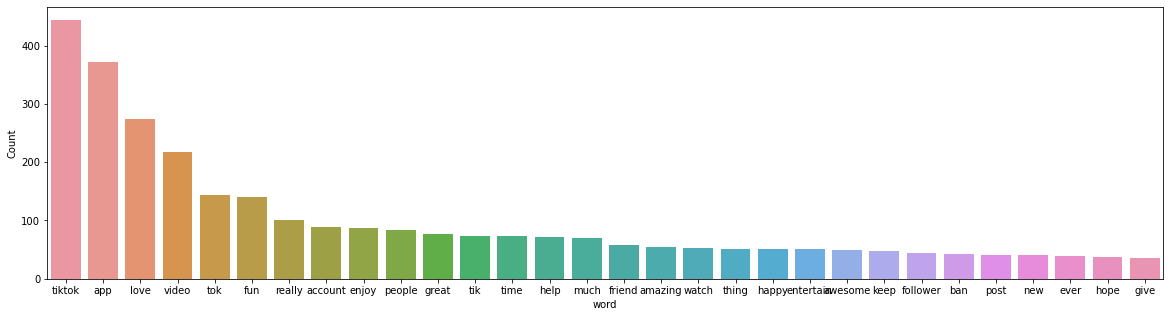

In [88]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score5))


In [89]:
# Create Dictionary
id2word_sg_score5 = corpora.Dictionary(review_sg_ready_score5)

In [90]:
# Create Corpus: Term Document Frequency
corpus_sg_score5 = [id2word_sg_score5.doc2bow(text) for text in review_sg_ready_score5]

In [91]:
# Training LDA model
model_list_sg_score5, coherence_values_sg_score5 = compute_coherence_values(dictionary=id2word_sg_score5, corpus=corpus_sg_score5, 
                                                              texts=review_sg_ready_score5, limit=30, start=2, step=5)


In [98]:
%store model_list_sg_score5
%store coherence_values_sg_score5

Stored 'model_list_sg_score5' (list)
Stored 'coherence_values_sg_score5' (list)


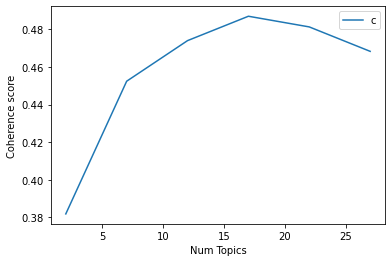

In [92]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [93]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3818
index: 1 | Num Topics = 7  has Coherence Value of 0.4524
index: 2 | Num Topics = 12  has Coherence Value of 0.4741
index: 3 | Num Topics = 17  has Coherence Value of 0.487
index: 4 | Num Topics = 22  has Coherence Value of 0.4813
index: 5 | Num Topics = 27  has Coherence Value of 0.4683


In [106]:
# Select optimal number of topics
optimal_model_sg_score5 = model_list_sg_score5[3]

In [107]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score5 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score5, corpus_sg_score5, id2word_sg_score5)

In [108]:
print("pyLDAVis for SG topics for score=5:")
vis_sg_score5

pyLDAVis for SG topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.197297  0.231481       1        1  11.560219
1      0.145455 -0.068899       2        1  10.353293
0      0.195005 -0.051290       3        1   9.730938
2      0.256253 -0.017307       4        1   9.639138
9     -0.109081  0.288621       5        1   8.056665
7      0.154749 -0.025616       6        1   6.961578
5     -0.068836  0.066242       7        1   6.871685
11    -0.036614 -0.046657       8        1   6.693399
16    -0.116515  0.173938       9        1   5.995765
15    -0.069569 -0.104296      10        1   4.763466
6     -0.097277  0.086634      11        1   4.008142
13    -0.095800 -0.023031      12        1   3.424658
14    -0.073832 -0.106913      13        1   3.103187
3     -0.060843 -0.094903      14        1   2.668960
12    -0.082273 -0.106150      15        1   2.495264
8     -0.066822 -0.105989      16        1   2.222482
10    -0.071297 -0.095864      17        1   1.451161, topic_info=            Term        Freq       Total Category  logprob  loglift
21          love  191.000000  191.000000  Default  30.0000  30.0000
0            fun  128.000000  128.000000  Default  29.0000  29.0000
37        tiktok  465.000000  465.000000  Default  28.0000  28.0000
3            app  322.000000  322.000000  Default  27.0000  27.0000
32         video  165.000000  165.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1408        minh    0.054893    1.038955  Topic17  -7.6246   1.2922
1509  disclaimer    0.054859    1.038514  Topic17  -7.6252   1.2920
1080       aloud    0.054827    1.038449  Topic17  -7.6258   1.2915
1113        mark    0.054818    1.038450  Topic17  -7.6260   1.2913
1110      spread    0.054818    1.038769  Topic17  -7.6260   1.2910

[677 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
620       2  0.810738          able
602       2  0.523705           acc
602      14  0.349136           acc
391      11  0.353116  accidentally
391      12  0.353116  accidentally
...     ...       ...           ...
70       13  0.584102          感谢厚爱
1016     15  0.633691   我看不懂english
71       13  0.584102          承蒙不弃
293      15  0.633711  整体都很好但是一直被限流
887       8  0.436999           非常好

[771 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 10, 8, 6, 12, 17, 16, 7, 14, 15, 4, 13, 9, 11])

## LDA Topic Modelling (Rating = 1,2,3)

In [115]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_sg_score1N2N3 = tiktok_ios_sg_review_YearMonth_score1N2N3.review.values.tolist()
review_words_sg_score1N2N3 = list(sent_to_words(review_sg_score1N2N3))
print(review_words_sg_score1N2N3[:1])

[['waited', 'for', 'this', 'app', 'to', 'download', 'for', 'about', 'an', 'hour', 'and', 'it', 'still', 'hasn', 'download', 'yet']]


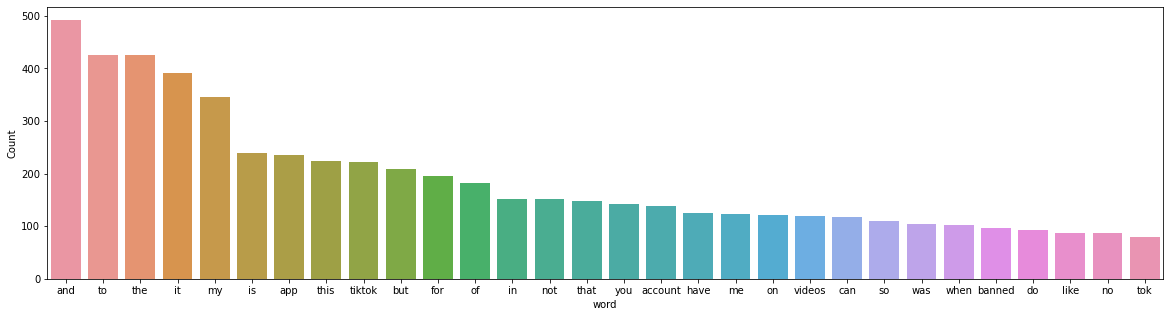

In [116]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1N2N3))

In [117]:
# Clean text
review_sg_ready_score1N2N3 = process_words(review_words_sg_score1N2N3)  # processed Text Data! - move to each section

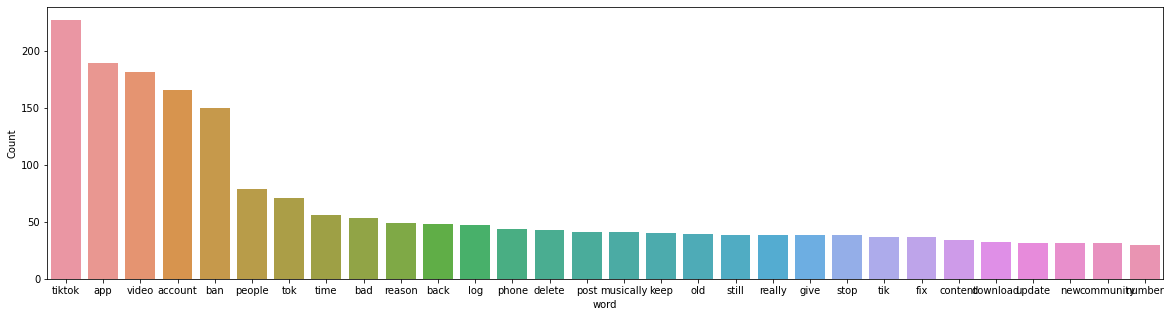

In [118]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1N2N3))


In [119]:
# Create Dictionary
id2word_sg_score1N2N3 = corpora.Dictionary(review_sg_ready_score1N2N3)

In [120]:
# Create Corpus: Term Document Frequency
corpus_sg_score1N2N3 = [id2word_sg_score1N2N3.doc2bow(text) for text in review_sg_ready_score1N2N3]

In [121]:
# Training LDA model
model_list_sg_score1N2N3, coherence_values_sg_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_score1N2N3, corpus=corpus_sg_score1N2N3, 
                                                              texts=review_sg_ready_score1N2N3, limit=30, start=2, step=5)


In [122]:
%store model_list_sg_score1N2N3
%store coherence_values_sg_score1N2N3

Stored 'model_list_sg_score1N2N3' (list)
Stored 'coherence_values_sg_score1N2N3' (list)


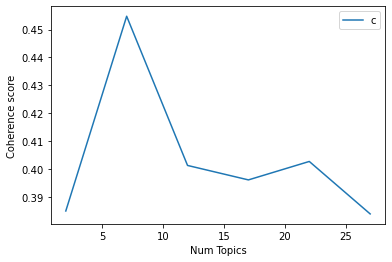

In [124]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3849
index: 1 | Num Topics = 7  has Coherence Value of 0.4548
index: 2 | Num Topics = 12  has Coherence Value of 0.4012
index: 3 | Num Topics = 17  has Coherence Value of 0.396
index: 4 | Num Topics = 22  has Coherence Value of 0.4027
index: 5 | Num Topics = 27  has Coherence Value of 0.3838


In [126]:
# Select optimal number of topics
optimal_model_sg_score1N2N3 = model_list_sg_score1N2N3[1]

In [127]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1N2N3, corpus_sg_score1N2N3, id2word_sg_score1N2N3)

In [133]:
print("pyLDAVis for SG topics for score=1,2,3:")
vis_sg_score1N2N3

pyLDAVis for SG topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.129951  0.101737       1        1  25.639668
6      0.105690 -0.143074       2        1  23.218686
4      0.057274  0.029033       3        1  17.138283
0     -0.031302 -0.057297       4        1  10.264575
2     -0.156799 -0.004935       5        1   8.690627
3     -0.036058  0.085494       6        1   7.834375
5     -0.068755 -0.010958       7        1   7.213787, topic_info=          Term        Freq       Total Category  logprob  loglift
471        ban  129.000000  129.000000  Default  30.0000  30.0000
22     account  141.000000  141.000000  Default  29.0000  29.0000
14         tok   61.000000   61.000000  Default  28.0000  28.0000
92      people   64.000000   64.000000  Default  27.0000  27.0000
144        bad   44.000000   44.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
690  community    2.246920   26.767599   Topic7  -5.3267   0.1515
71      tiktok    2.921602  189.002954   Topic7  -5.0642  -1.5405
362       stop    1.995956   32.942884   Topic7  -5.4452  -0.1745
338       star    1.776700   21.329674   Topic7  -5.5615   0.1438
63         old    1.784302   33.058480   Topic7  -5.5573  -0.2901

[444 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
108       2  0.646512      acc
108       3  0.092359      acc
108       4  0.184718      acc
22        1  0.409949  account
22        2  0.339268  account
...     ...       ...      ...
1000      6  0.877468      wut
5         2  0.809078      yet
5         7  0.202269      yet
697       6  0.268889    young
697       7  0.537777    young

[773 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 5, 1, 3, 4, 6])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [170]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_sg_2018_score1N2N3 = tiktok_ios_sg_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_sg_2018_score1N2N3 = list(sent_to_words(review_sg_2018_score1N2N3))
print(review_words_sg_2018_score1N2N3[:1])

[['waited', 'for', 'this', 'app', 'to', 'download', 'for', 'about', 'an', 'hour', 'and', 'it', 'still', 'hasn', 'download', 'yet']]


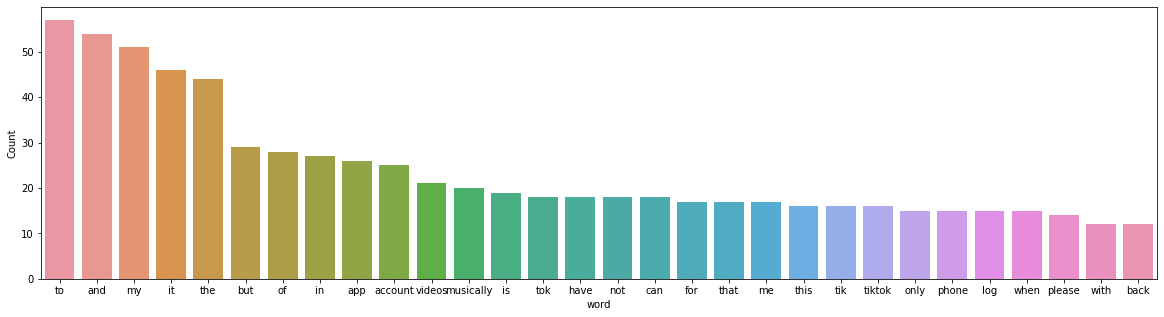

In [171]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2018_score1N2N3))

In [172]:
# Clean text
review_words_sg_ready_2018_score1N2N3 = process_words(review_words_sg_2018_score1N2N3)  # processed Text Data! - move to each section

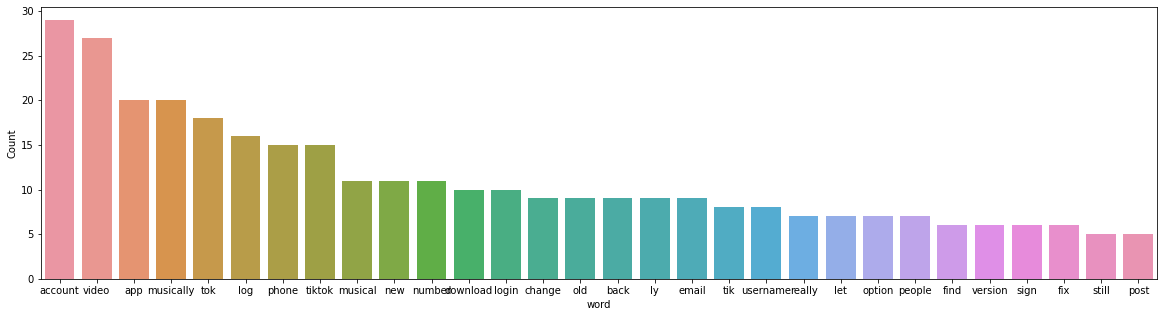

In [173]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2018_score1N2N3))


In [174]:
# Create Dictionary
id2word_sg_2018_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2018_score1N2N3)

In [175]:
# Create Corpus: Term Document Frequency
corpus_sg_2018_score1N2N3 = [id2word_sg_2018_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2018_score1N2N3]

In [176]:
# Training LDA model
model_list_sg_2018_score1N2N3, coherence_values_sg_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2018_score1N2N3, corpus=corpus_sg_2018_score1N2N3, 
                                                              texts=review_words_sg_ready_2018_score1N2N3, limit=30, start=2, step=5)


In [177]:
%store model_list_sg_2018_score1N2N3
%store coherence_values_sg_2018_score1N2N3

Stored 'model_list_sg_2018_score1N2N3' (list)
Stored 'coherence_values_sg_2018_score1N2N3' (list)


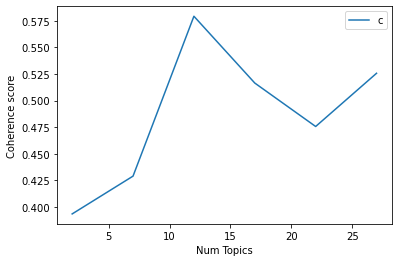

In [178]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [179]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3934
index: 1 | Num Topics = 7  has Coherence Value of 0.4289
index: 2 | Num Topics = 12  has Coherence Value of 0.5794
index: 3 | Num Topics = 17  has Coherence Value of 0.5165
index: 4 | Num Topics = 22  has Coherence Value of 0.4756
index: 5 | Num Topics = 27  has Coherence Value of 0.5257


In [180]:
# Select optimal number of topics
optimal_model_sg_2018_score1N2N3 = model_list_sg_2018_score1N2N3[2]

In [182]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2018_score1N2N3, corpus_sg_2018_score1N2N3, id2word_sg_2018_score1N2N3)

In [239]:
print("pyLDAVis for SG topics for score=1,2,3 in 2018:")
vis_sg_2018_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.001929  0.032245       1        1  16.506386
3     -0.101917  0.087498       2        1  15.244624
9      0.182410  0.007315       3        1  10.855963
7     -0.078089 -0.124768       4        1  10.610697
11    -0.059161  0.147389       5        1   9.192467
1     -0.066348 -0.073668       6        1   8.739044
0      0.060804  0.034020       7        1   6.387345
5      0.000977  0.044308       8        1   5.701998
4      0.008258 -0.112436       9        1   5.521480
2      0.136685 -0.008878      10        1   5.449794
8     -0.110356 -0.019503      11        1   5.163135
10     0.028665 -0.013523      12        1   0.627067, topic_info=         Term      Freq      Total Category  logprob  loglift
22    account  22.00000  22.000000  Default  30.0000  30.0000
20      video  20.00000  20.000000  Default  29.0000  29.0000
8     musical   8.00000   8.000000  Default  28.0000  28.0000
106        ly   7.00000   7.000000  Default  27.0000  27.0000
71     tiktok  11.00000  11.000000  Default  26.0000  26.0000
..        ...       ...        ...      ...      ...      ...
126      sign   0.01588   4.890421  Topic12  -5.6276  -0.6581
137  follower   0.01588   2.591078  Topic12  -5.6276  -0.0229
2        hour   0.01588   1.427177  Topic12  -5.6276   0.5735
3       still   0.01588   4.442404  Topic12  -5.6276  -0.5620
4        wait   0.01588   2.227079  Topic12  -5.6276   0.1285

[515 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
32        1  0.767202       able
108       7  0.515801        acc
108      10  0.515801        acc
247       2  0.682404     access
22        1  0.134550    account
...     ...       ...        ...
115       7  0.477953       year
5         4  0.700684        yet
73       11  0.766110  不要單獨搞簡中版本
50        2  0.682404         抖音
267       5  0.718779    没有中国版的吗

[470 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 10, 8, 12, 2, 1, 6, 5, 3, 9, 11])

## By-rating of 2019 (Rating=1,2,3)

In [184]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_sg_2019_score1N2N3 = tiktok_ios_sg_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_sg_2019_score1N2N3 = list(sent_to_words(review_sg_2019_score1N2N3))
print(review_words_sg_2019_score1N2N3[:1])

[['have', 'seen', 'so', 'many', 'people', 'in', 'tik', 'tok', 'not', 'acting', 'their', 'age', 'and', 'yr', 'old', 'over', 'sexuallises', 'her', 'pictures', 'using', 'photoshop', 'and', 'is', 'dating', 'an', 'yr', 'old', 'full', 'grown', 'man', 'ready', 'to', 'go', 'into', 'ns', 'in', 'sg', 'like', 'who', 'does', 'that', 'and', 'makes', 'yr', 'olds', 'see', 'that', 'it', 'harms', 'them', 'so', 'parents', 'hope', 'that', 'you', 'see', 'this', 'review', 'and', 'say', 'no', 'until', 'you', 're', 'will', 'thank', 'you', 'for', 'keeping', 'our', 'youngest', 'safe']]


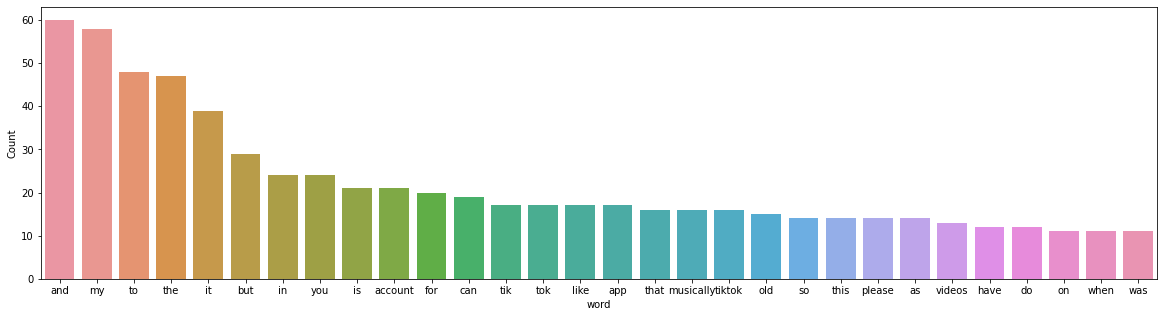

In [185]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2019_score1N2N3))

In [186]:
# Clean text
review_words_sg_ready_2019_score1N2N3 = process_words(review_words_sg_2019_score1N2N3)  # processed Text Data! - move to each section

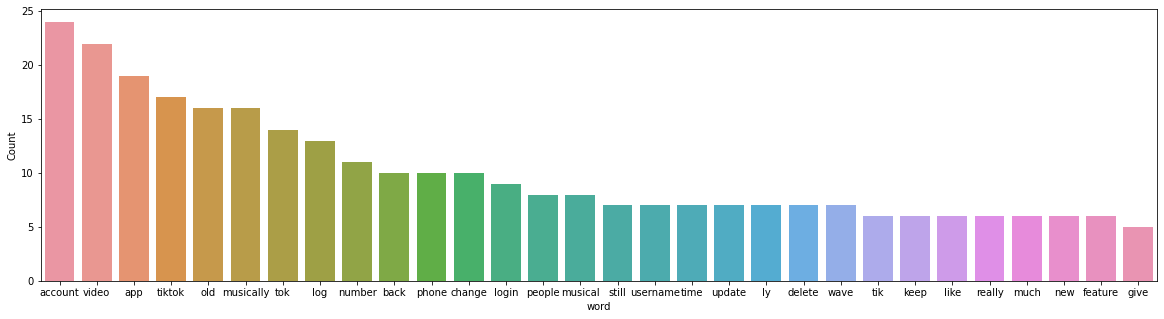

In [187]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2019_score1N2N3))


In [188]:
# Create Dictionary
id2word_sg_2019_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2019_score1N2N3)

In [189]:
# Create Corpus: Term Document Frequency
corpus_sg_2019_score1N2N3 = [id2word_sg_2019_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2019_score1N2N3]

In [190]:
# Training LDA model
model_list_sg_2019_score1N2N3, coherence_values_sg_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2019_score1N2N3, corpus=corpus_sg_2019_score1N2N3, 
                                                              texts=review_words_sg_ready_2019_score1N2N3, limit=30, start=2, step=5)


In [191]:
%store model_list_sg_2019_score1N2N3
%store coherence_values_sg_2019_score1N2N3

Stored 'model_list_sg_2019_score1N2N3' (list)
Stored 'coherence_values_sg_2019_score1N2N3' (list)


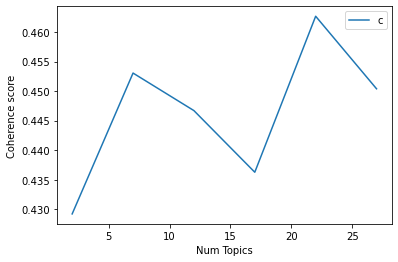

In [228]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [234]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.4292
index: 1 | Num Topics = 7  has Coherence Value of 0.453
index: 2 | Num Topics = 12  has Coherence Value of 0.4467
index: 3 | Num Topics = 17  has Coherence Value of 0.4363
index: 4 | Num Topics = 22  has Coherence Value of 0.4627
index: 5 | Num Topics = 27  has Coherence Value of 0.4504


In [236]:
# Select optimal number of topics
optimal_model_sg_2019_score1N2N3 = model_list_sg_2019_score1N2N3[1]

In [237]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2019_score1N2N3, corpus_sg_2019_score1N2N3, id2word_sg_2019_score1N2N3)

In [238]:
print("pyLDAVis for SG topics for score=1,2,3 in 2019:")
vis_sg_2019_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.106150  0.131138       1        1  28.524327
5      0.107310 -0.066886       2        1  17.557839
1      0.033023 -0.121591       3        1  14.181312
4     -0.043144  0.059608       4        1  13.341729
6     -0.137002  0.019525       5        1  13.148321
0     -0.065555 -0.038630       6        1  10.807808
3     -0.000783  0.016836       7        1   2.438664, topic_info=          Term       Freq      Total Category  logprob  loglift
81       video  15.000000  15.000000  Default   30.000  30.0000
92      tiktok  12.000000  12.000000  Default   29.000  29.0000
108     number   8.000000   8.000000  Default   28.000  28.0000
9          old  12.000000  12.000000  Default   27.000  27.0000
53   musically  12.000000  12.000000  Default   26.000  26.0000
..         ...        ...        ...      ...      ...      ...
262     iphone   0.044561   4.620055   Topic7   -5.961  -0.9276
219       wave   0.044561   6.208717   Topic7   -5.961  -1.2231
223       live   0.044561   1.442718   Topic7   -5.961   0.2363
224     stream   0.044561   1.442718   Topic7   -5.961   0.2363
25       great   0.044561   2.844319   Topic7   -5.961  -0.4425

[373 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
54        1  0.469550      able
54        4  0.469550      able
278       2  0.729980        ac
296       1  0.894030    access
39        1  0.383780   account
...     ...       ...       ...
209       4  0.494464      work
48        2  0.594606     wrong
49        2  0.956300      year
21        4  0.748836  youngest
98        4  0.748847       没用的

[385 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 5, 7, 1, 4])

## By-rating of 2020 (Rating=1,2,3)

In [192]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_sg_2020_score1N2N3 = tiktok_ios_sg_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_sg_2020_score1N2N3 = list(sent_to_words(review_sg_2020_score1N2N3))
print(review_words_sg_2020_score1N2N3[:1])

[['didnt', 'get', 'feature', 'using', 'an', 'iphone', 'pro', 'max', 'it', 'the', 'profile', 'video', 'feature', 'ughhhh', 'plz', 'fix', 'this', 'problem']]


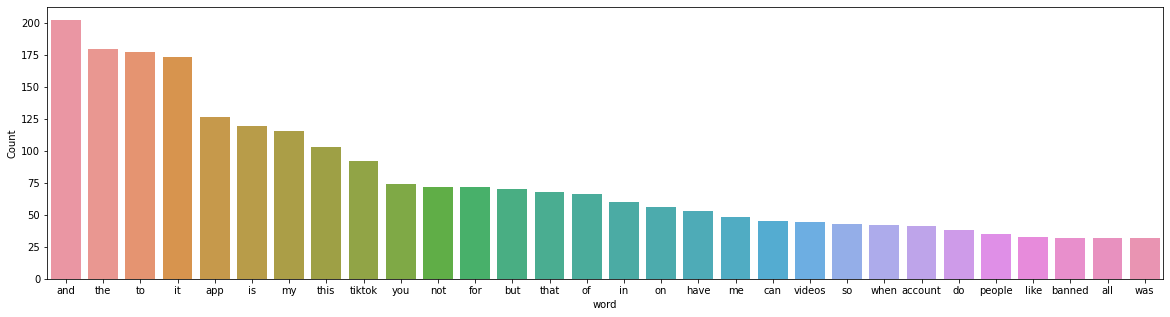

In [193]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2020_score1N2N3))

In [194]:
# Clean text
review_words_sg_ready_2020_score1N2N3 = process_words(review_words_sg_2020_score1N2N3)  # processed Text Data! - move to each section

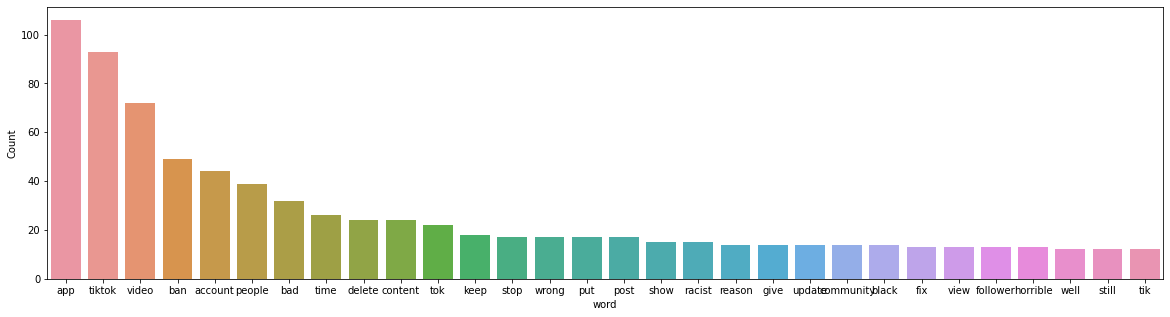

In [195]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2020_score1N2N3))


In [196]:
# Create Dictionary
id2word_sg_2020_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2020_score1N2N3)

In [197]:
# Create Corpus: Term Document Frequency
corpus_sg_2020_score1N2N3 = [id2word_sg_2020_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2020_score1N2N3]

In [198]:
# Training LDA model
model_list_sg_2020_score1N2N3, coherence_values_sg_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2020_score1N2N3, corpus=corpus_sg_2020_score1N2N3, 
                                                              texts=review_words_sg_ready_2020_score1N2N3, limit=30, start=2, step=5)


In [199]:
%store model_list_sg_2020_score1N2N3
%store coherence_values_sg_2020_score1N2N3

Stored 'model_list_sg_2020_score1N2N3' (list)
Stored 'coherence_values_sg_2020_score1N2N3' (list)


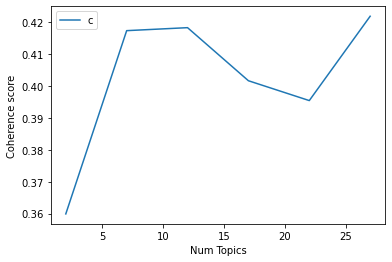

In [218]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [220]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3599
index: 1 | Num Topics = 7  has Coherence Value of 0.4173
index: 2 | Num Topics = 12  has Coherence Value of 0.4183
index: 3 | Num Topics = 17  has Coherence Value of 0.4016
index: 4 | Num Topics = 22  has Coherence Value of 0.3954
index: 5 | Num Topics = 27  has Coherence Value of 0.4219


In [225]:
# Select optimal number of topics
optimal_model_sg_2020_score1N2N3 = model_list_sg_2020_score1N2N3[5]

In [226]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2020_score1N2N3, corpus_sg_2020_score1N2N3, id2word_sg_2020_score1N2N3)

In [227]:
print("pyLDAVis for SG topics for score=1,2,3 in 2020:")
vis_sg_2020_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.141654  0.013825       1        1  7.222152
24     0.145330 -0.039790       2        1  7.001482
22     0.078397 -0.033390       3        1  6.807958
1      0.040077  0.007921       4        1  5.658887
20     0.114239 -0.027325       5        1  5.645580
13    -0.016939 -0.071177       6        1  5.522540
18     0.105064  0.107582       7        1  5.423683
25     0.110500  0.084366       8        1  5.368621
15    -0.064962 -0.022669       9        1  4.530483
10    -0.016208  0.044108      10        1  3.634674
21     0.030011  0.020554      11        1  3.423759
11     0.003548 -0.144755      12        1  3.402873
8     -0.020926  0.100641      13        1  3.364610
19     0.022428 -0.008354      14        1  3.355674
6     -0.056149 -0.024080      15        1  3.245130
23    -0.027976 -0.031123      16        1  3.229297
5     -0.069970  0.042944      17        1  3.054686
16    -0.000204 -0.129234      18        1  3.038286
26    -0.028634 -0.123262      19        1  2.918166
0     -0.042734  0.113106      20        1  2.569075
3     -0.059276  0.032877      21        1  2.504723
17    -0.047019  0.012860      22        1  2.132459
4     -0.034073 -0.074945      23        1  1.988107
12     0.007093  0.063869      24        1  1.712287
14    -0.176499  0.034199      25        1  1.667415
2     -0.047668  0.025507      26        1  0.897278
9     -0.089103  0.025746      27        1  0.680117, topic_info=        Term       Freq      Total Category  logprob  loglift
54       bad  21.000000  21.000000  Default  30.0000  30.0000
39   account  35.000000  35.000000  Default  29.0000  29.0000
28       app  80.000000  80.000000  Default  28.0000  28.0000
10       ban  38.000000  38.000000  Default  27.0000  27.0000
8      video  57.000000  57.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
455  support   0.015027   4.303883  Topic27  -7.1164  -0.6668
28       app   0.015027  80.747976  Topic27  -7.1164  -3.5986
548     user   0.015027   6.079856  Topic27  -7.1164  -1.0122
723   doctor   0.015027   3.204559  Topic27  -7.1164  -0.3718
728   tumour   0.015027   2.373351  Topic27  -7.1164  -0.0716

[1355 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
283       3  0.530444            able
283       7  0.265222            able
283      24  0.265222            able
401      15  0.696166           abuse
885      13  0.688813             acc
...     ...       ...             ...
311      11  0.216668           youth
311      19  0.216668           youth
157      20  0.718262  凭什么在海外就不能下在中国版
158      20  0.718262          建立了一个吧
159      20  0.718262  说不能下载必须换回新加坡商城

[1674 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 25, 23, 2, 21, 14, 19, 26, 16, 11, 22, 12, 9, 20, 7, 24, 6, 17, 27, 1, 4, 18, 5, 13, 15, 3, 10])

## By-rating of 2021 (Rating=1,2,3)

In [200]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_sg_2021_score1N2N3 = tiktok_ios_sg_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_sg_2021_score1N2N3 = list(sent_to_words(review_sg_2021_score1N2N3))
print(review_words_sg_2021_score1N2N3[:1])

[['im', 'filming', 'halfway', 'and', 'tiktok', 'keeps', 'stopping', 'my', 'video', 'and', 'have', 'to', 'refilm', 'everything', 'which', 'is', 'so', 'annoying', 'and', 'have', 'encountered', 'this', 'problem', 'many', 'times', 'already', 'tiktok', 'please', 'do', 'something', 'about', 'this']]


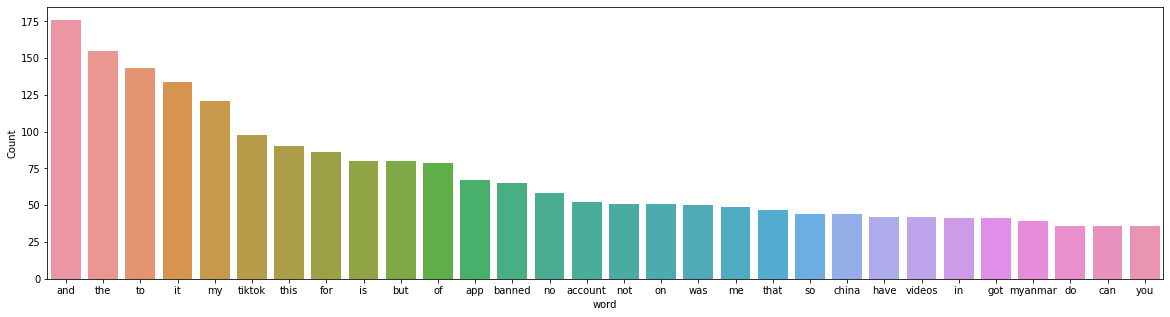

In [201]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2021_score1N2N3))

In [202]:
# Clean text
review_words_sg_ready_2021_score1N2N3 = process_words(review_words_sg_2021_score1N2N3)  # processed Text Data! - move to each section

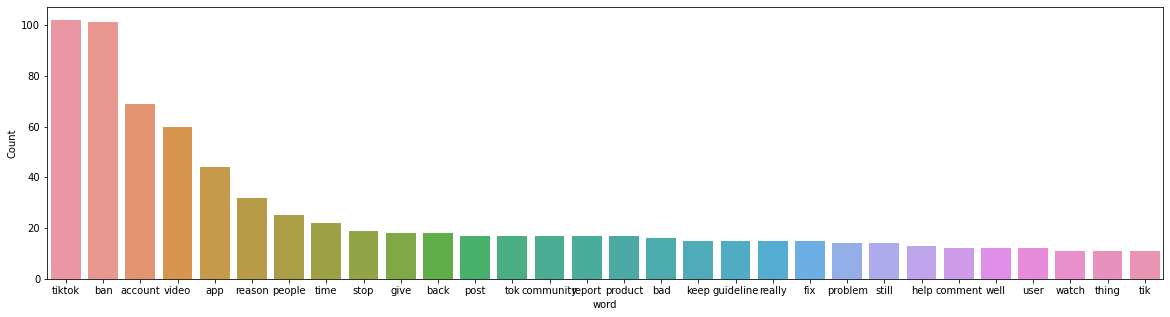

In [203]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2021_score1N2N3))


In [204]:
# Create Dictionary
id2word_sg_2021_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2021_score1N2N3)

In [205]:
# Create Corpus: Term Document Frequency
corpus_sg_2021_score1N2N3 = [id2word_sg_2021_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2021_score1N2N3]

In [206]:
# Training LDA model
model_list_sg_2021_score1N2N3, coherence_values_sg_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2021_score1N2N3, corpus=corpus_sg_2021_score1N2N3, 
                                                              texts=review_words_sg_ready_2021_score1N2N3, limit=30, start=2, step=5)


In [207]:
%store model_list_sg_2021_score1N2N3
%store coherence_values_sg_2021_score1N2N3

Stored 'model_list_sg_2021_score1N2N3' (list)
Stored 'coherence_values_sg_2021_score1N2N3' (list)


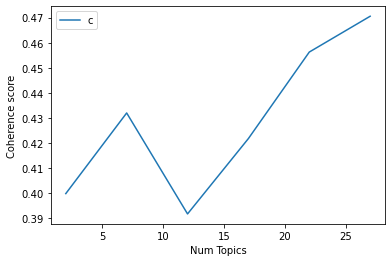

In [208]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [209]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.3999
index: 1 | Num Topics = 7  has Coherence Value of 0.432
index: 2 | Num Topics = 12  has Coherence Value of 0.3918
index: 3 | Num Topics = 17  has Coherence Value of 0.4218
index: 4 | Num Topics = 22  has Coherence Value of 0.4563
index: 5 | Num Topics = 27  has Coherence Value of 0.4705


In [215]:
# Select optimal number of topics
optimal_model_sg_2021_score1N2N3 = model_list_sg_2021_score1N2N3[5]

In [216]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2021_score1N2N3, corpus_sg_2021_score1N2N3, id2word_sg_2021_score1N2N3)

In [217]:
print("pyLDAVis for SG topics for score=1,2,3 in 2021:")
vis_sg_2021_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.077657 -0.105545       1        1  7.701790
7      0.175884  0.064278       2        1  7.245824
18     0.106748 -0.002628       3        1  6.758363
0     -0.007633 -0.120238       4        1  6.475782
20     0.058629 -0.043789       5        1  6.457251
21     0.012326 -0.005714       6        1  6.026880
25     0.137676 -0.021755       7        1  5.970153
1      0.170550  0.055356       8        1  5.856825
19    -0.051798 -0.240791       9        1  5.590115
14     0.091468  0.041914      10        1  5.485061
10     0.137458  0.046775      11        1  5.359300
24     0.092744 -0.081808      12        1  4.200311
22    -0.030896 -0.005709      13        1  3.655532
4      0.006399  0.007605      14        1  2.879062
13    -0.140111  0.060636      15        1  2.750122
9     -0.059044  0.106181      16        1  2.656408
16    -0.045962 -0.042917      17        1  2.140060
5     -0.065634  0.024667      18        1  2.003361
17    -0.070652  0.066981      19        1  1.853065
12     0.062670  0.075935      20        1  1.498008
3     -0.102900  0.014472      21        1  1.486360
8     -0.121561 -0.027617      22        1  1.354231
26    -0.080270  0.043321      23        1  1.333811
11    -0.050389  0.013989      24        1  1.259216
2     -0.121367 -0.021633      25        1  1.033292
23    -0.084249  0.053926      26        1  0.586995
6     -0.097740  0.044107      27        1  0.382824, topic_info=        Term       Freq      Total Category  logprob  loglift
13   account  54.000000  54.000000  Default  30.0000  30.0000
14       ban  81.000000  81.000000  Default  29.0000  29.0000
78       bad   9.000000   9.000000  Default  28.0000  28.0000
47       app  32.000000  32.000000  Default  27.0000  27.0000
253  product  13.000000  13.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
22       one   0.010565   2.073517  Topic27  -6.7142   0.2859
23      post   0.010565  14.414584  Topic27  -6.7142  -1.6531
24    reason   0.010565  25.761559  Topic27  -6.7142  -2.2338
25      rule   0.010565   3.937132  Topic27  -6.7142  -0.3553
26   violate   0.010565   8.723953  Topic27  -6.7142  -1.1509

[1291 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
606      13  0.688464   able
309       3  0.660451    abt
214       3  0.660450  abuse
156       1  0.133475    acc
156       3  0.400424    acc
...     ...       ...    ...
81        6  0.168863   year
81       11  0.337726   year
81       23  0.168863   year
81       24  0.168863   year
45       13  0.688465   yooo

[1347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 8, 19, 1, 21, 22, 26, 2, 20, 15, 11, 25, 23, 5, 14, 10, 17, 6, 18, 13, 4, 9, 27, 12, 3, 24, 7])

# Export pyLDAvis as html

In [242]:
# Overall
pyLDAvis.save_html(vis_sg,'vis_sg.html')

# By-rating 
pyLDAvis.save_html(vis_sg_score1,'vis_sg_score1.html')
pyLDAvis.save_html(vis_sg_score2,'vis_sg_score2.html')
pyLDAvis.save_html(vis_sg_score3,'vis_sg_score3.html')
pyLDAvis.save_html(vis_sg_score4,'vis_sg_score4.html')
pyLDAvis.save_html(vis_sg_score5,'vis_sg_score5.html')
pyLDAvis.save_html(vis_sg_score1N2N3,'vis_sg_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_sg_2021_score1N2N3,'vis_sg_2021_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2020_score1N2N3,'vis_sg_2020_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2019_score1N2N3,'vis_sg_2019_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2018_score1N2N3,'vis_sg_2018_score1N2N3.html')

